# The Seq2Seq Georgian Verb Conjugator Model

In this notebook we will: 

- Set up Encoder, Decoder and Seq2Seq classes
- process the prepared data

In [77]:
# import necessary libraries
import ast 
import random
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# import stored data for input and output dimensions in the model
%store -r feature_vocab_dict
%store -r target_vocab_dict

In [78]:
# Function to load and properly convert the sequences
def load_sequence_json(path):
    df = pd.read_json(path)
    return [ast.literal_eval(str(row[0])) for row in df.values]

# Load the sequences from the JSON files
X_train = load_sequence_json(r"..\data\train-test-eval\X_train.json")
y_train = load_sequence_json(r"..\data\train-test-eval\y_train.json")
X_val = load_sequence_json(r"..\data\train-test-eval\X_val.json")
y_val = load_sequence_json(r"..\data\train-test-eval\y_val.json")
X_test = load_sequence_json(r"..\data\train-test-eval\X_test.json")
y_test = load_sequence_json(r"..\data\train-test-eval\y_test.json")

# Check the loaded sequences
print("X_train:", X_train[:2])  # Print first two examples for verification
print("y_train:", y_train[:2])  # Print first two examples for verification

X_train: [['<bos>', 'ა', 'შ', 'ე', 'ნ', 'ე', 'ბ', 'ს', 'ARGNO2S', 'ARGAC1S', 'IND', 'PRS', '<eos>'], ['<bos>', 'წ', 'ო', 'ნ', 'ი', 'ს', 'ARGNO2P', 'ARGAC3P', 'IND', 'PST', 'PRF', '<eos>']]
y_train: [['<bos>', 'მ', 'ა', 'შ', 'ე', 'ნ', 'ე', 'ბ', '<eos>'], ['<bos>', 'ა', 'გ', 'ე', 'წ', 'ო', 'ნ', 'ა', 'თ', '<eos>']]


In [79]:
# Encode the datasets into their index representations
X_train_idx = [[feature_vocab_dict[token] for token in sequence] for sequence in X_train]
X_val_idx = [[feature_vocab_dict[token] for token in sequence] for sequence in X_val]
X_test_idx = [[feature_vocab_dict[token] for token in sequence] for sequence in X_test]

print("Encoded X_train_idx:", X_train_idx[:2])  # Print first two examples for verification
print("Encoded X_val_idx:", X_val_idx[:2])    # Print first two examples for verification
print("Encoded X_test_idx:", X_test_idx[:2])  # Print first two examples for verification

# Encode the target datasets into their index representations
y_train_idx = [[target_vocab_dict[token] for token in sequence] for sequence in y_train]
y_val_idx = [[target_vocab_dict[token] for token in sequence] for sequence in y_val]
y_test_idx = [[target_vocab_dict[token] for token in sequence] for sequence in y_test]

print("Encoded y_train_idx:", y_train_idx[:2])  # Print first two examples for verification
print("Encoded y_val_idx:", y_val_idx[:2])    # Print first two examples for verification
print("Encoded y_test_idx:", y_test_idx[:2])  # Print first two examples for verification

Encoded X_train_idx: [[1, 3, 27, 7, 15, 7, 4, 20, 45, 37, 51, 56, 2], [1, 31, 16, 15, 11, 20, 44, 40, 51, 57, 55, 2]]
Encoded X_val_idx: [[1, 7, 33, 14, 3, 19, 7, 4, 3, 43, 39, 51, 49, 2], [1, 3, 33, 19, 28, 16, 4, 20, 45, 41, 51, 55, 2]]
Encoded X_test_idx: [[1, 22, 20, 14, 7, 15, 20, 47, 37, 48, 2], [1, 3, 10, 7, 10, 19, 7, 4, 20, 47, 39, 51, 57, 55, 2]]
Encoded y_train_idx: [[1, 14, 3, 27, 7, 15, 7, 4, 2], [1, 3, 5, 7, 31, 16, 15, 3, 10, 2]]
Encoded y_val_idx: [[1, 6, 3, 5, 7, 33, 14, 3, 19, 7, 4, 11, 2], [1, 6, 3, 5, 11, 33, 19, 28, 8, 11, 3, 2]]
Encoded y_test_idx: [[1, 14, 16, 14, 11, 20, 14, 7, 15, 6, 3, 2], [1, 5, 3, 7, 10, 7, 10, 19, 7, 4, 11, 15, 7, 2]]


In [80]:
# implement the dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

## Encoder LSTM 

in the next cell we create an encoder LSTM class which will have:

- an embedding layer for the input vectors
- will output hidden states (short term memory) and cell states (long term memory), collectively called a context vector, that gets passed to the decoder

In [81]:
# implement encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        outputs, (hidden, cell) = self.rnn(embedded)  # hidden/cell: (2, batch, hidden_dim)

        # Transpose to (batch, 2, hidden_dim)
        hidden = hidden.transpose(0, 1)  # (batch, 2, hidden_dim)
        cell = cell.transpose(0, 1)      # (batch, 2, hidden_dim)

        # Concatenate forward and backward states (batch, hidden_dim * 2)
        hidden = torch.cat((hidden[:, 0, :], hidden[:, 1, :]), dim=1)
        cell = torch.cat((cell[:, 0, :], cell[:, 1, :]), dim=1)

        # Reduce to unidirectional hidden_dim (batch, hidden_dim)
        hidden = self.fc(hidden).unsqueeze(0)  # (1, batch, hidden_dim)
        cell = self.fc(cell).unsqueeze(0)      # (1, batch, hidden_dim)

        return hidden, cell

## Decoder LSTM

- Receives the context vector to initialize internal states (hidden/cell states).
- Embeds the output or target vectors 
- outputs a prediction and new hidden/cell states

In [82]:
# implement decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, dropout=0.5, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        embedded = self.embedding(x).unsqueeze(1) # (batch, 1, emb_dim)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

## Seq2Seq model

- The next cell is just comnbining the two cells above into one class and defines the forward pass for the model
- We use the classic se12seq architecture as proposed in Sutskever et al. 2014:
    - The encoder generates a context vector using source material (in our case the feature values) comprising of the last cell and hidden states it produces.
    - The context vector gets passed to the decoder which uses it to initialise its own parameters.
    - The decoder receives input in form of the target (in our case the target values) to predict an output sequence and operates until the end of a sequence (\<eos>) is reached.

In [83]:
# implement seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[1]
        batch_size = trg.shape[0]
        output_dim = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, output_dim).to(self.device)

        hidden, cell = self.encoder(src)

        x = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1) 
            x = trg[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

## training loop set-up

- Here, we define the architecture of the model:
    - we define the hyperparameters and parameters
    - we setup tensorboard logging
    - we define a collate function for batching, so that all batches are the same size while keeping them randomised
    - we setup the dataloaders using our custom datasets

In [84]:
import os
import json
import datetime
from pathlib import Path

class ExperimentTracker:
    def __init__(self, base_dir="experiments"):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Auto-generate experiment name
        existing_experiments = [d.name for d in self.base_dir.iterdir() if d.is_dir()]
        exp_numbers = [int(exp[10:]) for exp in existing_experiments if exp.startswith('experiment')]
        next_number = max(exp_numbers, default=0) + 1
        experiment_name = f"experiment{next_number:03d}"
        
        self.experiment_dir = self.base_dir / experiment_name
        self.experiment_dir.mkdir(exist_ok=True)
        self.results = {}
        
    def save_hyperparameters(self, hyperparams):
        with open(self.experiment_dir / "hyperparameters.json", 'w') as f:
            json.dump(hyperparams, f, indent=2)
    
    def log_epoch(self, epoch, train_loss=None, val_loss=None, train_acc=None, val_acc=None, test_loss=None, test_acc=None):
        epoch_key = f"epoch{epoch+1:03d}"
        self.results[epoch_key] = {}
        
        if train_loss is not None and train_acc is not None:
            self.results[epoch_key]["training"] = {"loss": round(train_loss, 4), "acc": round(train_acc, 4)}
        if val_loss is not None and val_acc is not None:
            self.results[epoch_key]["validation"] = {"loss": round(val_loss, 4), "acc": round(val_acc, 4)}
        if test_loss is not None and test_acc is not None:
            self.results[epoch_key]["test"] = {"loss": round(test_loss, 4), "acc": round(test_acc, 4)}
    
    def save_results(self):
        with open(self.experiment_dir / "results.json", 'w') as f:
            json.dump(self.results, f, indent=2)

In [85]:
### Training the model
# model hyperparameters
num_epochs = 200 
batch_size = 64
# optimizer hyperparameters
learning_rate = 0.0001

# training parameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim_encoder = len(feature_vocab_dict)
output_dim_decoder = len(target_vocab_dict)
encoder_emb_dim = 100 # refer to guriel et al. 
decoder_emb_dim = 100 # refer to guriel et al.
hidden_dim = 32

# tensorboard logging
writer = SummaryWriter('runs/seq2seq_experiment_1')
steps = 0
tracker = ExperimentTracker()
tracker.save_hyperparameters({"num_epochs": num_epochs, "batch_size": batch_size, "learning_rate": learning_rate, "hidden_dim": hidden_dim})

# setup data loaders with collate function
def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    X_batch = nn.utils.rnn.pad_sequence(X_batch, batch_first=True, padding_value=0)
    y_batch = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
    return X_batch, y_batch
# create datasets and dataloaders
train_dataset = CustomDataset(X_train_idx, y_train_idx)
val_dataset = CustomDataset(X_val_idx, y_val_idx)
test_dataset = CustomDataset(X_test_idx, y_test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Training loop

- here we setup the training loop and run it
- we add an evaluation loop every 5th epoch

In [86]:
# initialize encoder, decoder, and seq2seq model
encoder = Encoder(input_dim_encoder, encoder_emb_dim, hidden_dim).to(device)
decoder = Decoder(output_dim_decoder, decoder_emb_dim, hidden_dim).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=feature_vocab_dict['<pad>']) # ignore padding index in loss calculation

PAD_IDX = feature_vocab_dict['<pad>']
best_val_loss = float('inf')
patience = 5
counter = 0

#training loop
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, trg) in enumerate(train_loader):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate average loss
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    writer.add_scalar('Training Loss', avg_loss, global_step=epoch)

    # Calculate training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            pred = output.argmax(1)
            mask = trg_flat != PAD_IDX
            correct += (pred[mask] == trg_flat[mask]).sum().item()
            total += mask.sum().item()
    train_accuracy = accuracy_score(train_targets, train_predictions)

    # --- Validation every 5th epoch ---
    if (epoch + 1) % 2 == 0 or (epoch + 1) == num_epochs:
        model.eval()
        val_loss = 0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for src, trg in val_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg, teacher_forcing_ratio=0)
                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                trg_flat = trg[:, 1:].reshape(-1)
                loss = criterion(output, trg_flat)
                val_loss += loss.item()
                pred = output.argmax(1)
                mask = trg_flat != PAD_IDX
                val_predictions.extend(pred[mask].cpu().numpy())
                val_targets.extend(trg_flat[mask].cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        from sklearn.metrics import accuracy_score
        val_accuracy = accuracy_score(val_targets, val_predictions)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        writer.add_scalar('Validation Loss', avg_val_loss, global_step=epoch)
        writer.add_scalar('Validation Accuracy', val_accuracy, global_step=epoch)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), "best_seq2seq_model.pt")
            print("Model saved.")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
    # Log epoch results
    tracker.log_epoch(epoch, train_loss=avg_loss, train_acc=train_accuracy, val_loss=avg_val_loss if 'avg_val_loss' in locals() else None, val_acc=val_accuracy if 'val_accuracy' in locals() else None)

# Save results after training
tracker.save_results()

Starting training...


c:\Users\Home\anaconda3\envs\torchenv\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/200], Loss: 3.3763, Training Accuracy: 0.9154
Epoch [2/200], Loss: 2.8741, Training Accuracy: 0.1568
Validation Loss: 2.7560, Validation Accuracy: 0.2325
Model saved.
Epoch [3/200], Loss: 2.6746, Training Accuracy: 0.2323
Epoch [4/200], Loss: 2.5673, Training Accuracy: 0.2444
Validation Loss: 2.5855, Validation Accuracy: 0.2481
Model saved.
Epoch [5/200], Loss: 2.4813, Training Accuracy: 0.2466
Epoch [6/200], Loss: 2.4050, Training Accuracy: 0.2522
Validation Loss: 2.4907, Validation Accuracy: 0.2572
Model saved.
Epoch [7/200], Loss: 2.3443, Training Accuracy: 0.2550
Epoch [8/200], Loss: 2.2852, Training Accuracy: 0.2595
Validation Loss: 2.4145, Validation Accuracy: 0.2689
Model saved.
Epoch [9/200], Loss: 2.2306, Training Accuracy: 0.2683
Epoch [10/200], Loss: 2.1829, Training Accuracy: 0.2799
Validation Loss: 2.3356, Validation Accuracy: 0.2898
Model saved.
Epoch [11/200], Loss: 2.1390, Training Accuracy: 0.2866
Epoch [12/200], Loss: 2.0902, Training Accuracy: 0.2957
Validat

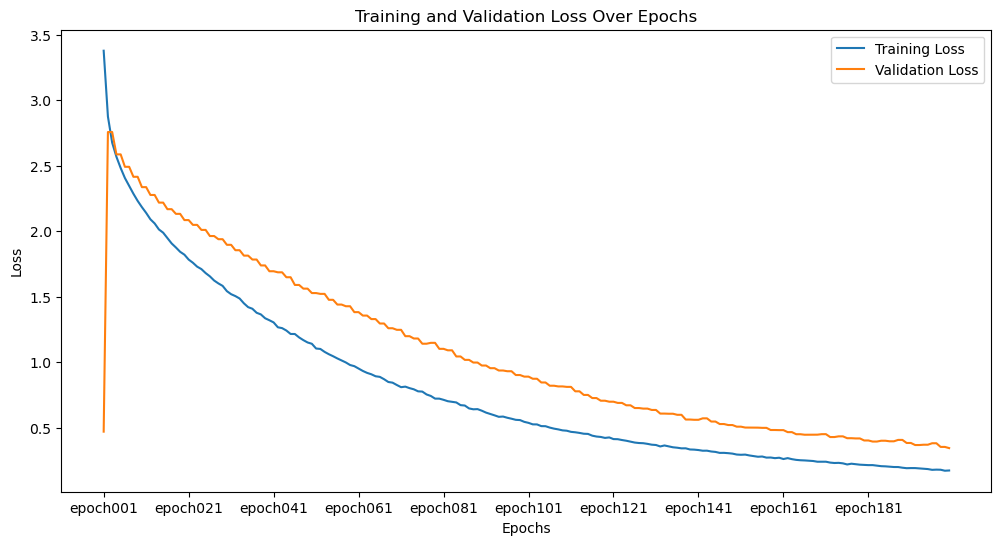

In [92]:
def visualize_results(results):
    epochs = list(results.keys())
    train_losses = [results[epoch].get("training", {}).get("loss", None) for epoch in epochs]
    val_losses = [results[epoch].get("validation", {}).get("loss", None) for epoch in epochs]
    val_accs = [results[epoch].get("validation", {}).get("acc", None) for epoch in epochs]

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(False) 
    # Show every 5th epoch label
    step = max(1, len(epochs) // 10)
    plt.xticks(epochs[::step])
    plt.show()

# Load the results from the JSON file
results_path = tracker.experiment_dir / "results.json"
with open(results_path, 'r') as f:
    results = json.load(f)
# Visualize the results
visualize_results(results)

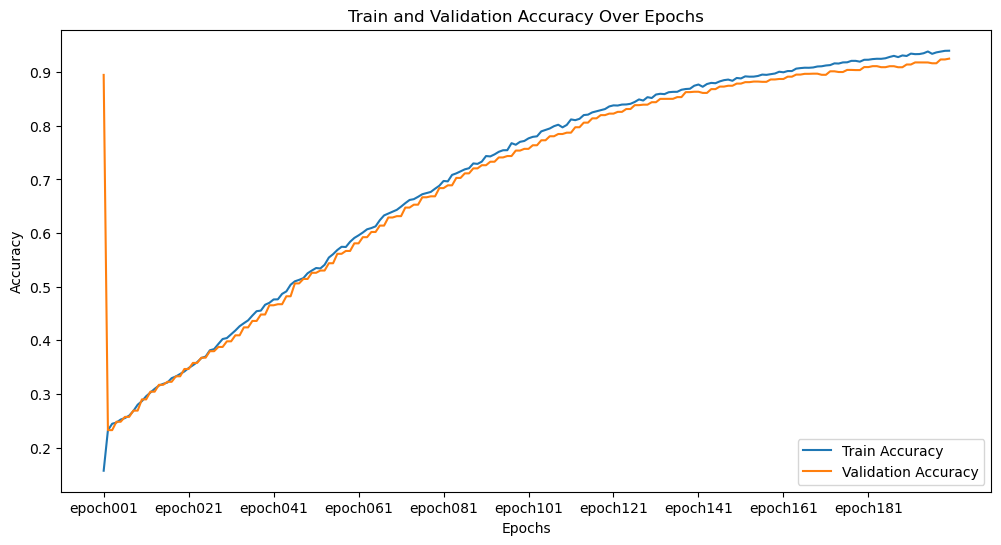

In [93]:
def plot_accuracy(results):
    epochs = list(results.keys())
    train_accs = [results[epoch].get("training", {}).get("acc", None) for epoch in epochs]
    val_accs = [results[epoch].get("validation", {}).get("acc", None) for epoch in epochs]

    plt.figure(figsize=(12, 6))
    if any(train_accs):
        plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(False)
    step = max(1, len(epochs) // 10)
    plt.xticks(epochs[::step])
    plt.show()

plot_accuracy(results)

In [89]:
PAD_IDX = feature_vocab_dict['<pad>']  # dynamically set padding index
target_idx_to_token = {idx: tok for tok, idx in target_vocab_dict.items()}

model.eval()
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for src, trg in test_loader:
        src, trg = src.to(device), trg.to(device)

        output = model(src, trg, teacher_forcing_ratio=0)  # no teacher forcing

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        test_loss += loss.item() * src.size(0)

        pred = output.argmax(1)
        mask = trg != PAD_IDX

        # Filter out pad tokens for accuracy
        filtered_pred = pred[mask].cpu().numpy()
        filtered_trg = trg[mask].cpu().numpy()

        test_predictions.extend(filtered_pred)
        test_targets.extend(filtered_trg)

        # Print 5 example sequences
        batch_size = src.size(0)
        seq_len = trg.view(batch_size, -1).size(1)
        pred_seq = pred.view(batch_size, -1)
        trg_seq = trg.view(batch_size, -1)

        for i in range(min(5, batch_size)):
            pred_tokens = [target_idx_to_token[idx.item()] for idx in pred_seq[i] if idx.item() != PAD_IDX]
            target_tokens = [target_idx_to_token[idx.item()] for idx in trg_seq[i] if idx.item() != PAD_IDX]

            print(f"Target   : {' '.join(target_tokens)}")
            print(f"Predicted: {' '.join(pred_tokens)}")
            print('-' * 40)

avg_test_loss = test_loss / len(test_dataset)
test_accuracy = accuracy_score(test_targets, test_predictions)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

writer.add_scalar('Test Loss', avg_test_loss, global_step=epoch)
writer.add_scalar('Test Accuracy', test_accuracy, global_step=epoch)

Target   : მ ო მ ი ს მ ე ნ დ ა <eos>
Predicted: მ ო მ ი ს მ ე ნ დ ა <eos> <eos> <eos> <eos> <eos> <eos>
----------------------------------------
Target   : გ ა ე თ ე თ რ ე ბ ი ნ ე <eos>
Predicted: გ ა ე თ ე თ რ ე ბ ი ნ ე <eos> <eos> <eos> <eos>
----------------------------------------
Target   : გ ვ ყ ო ფ დ ნ ე ნ <eos>
Predicted: გ ვ ყ ო ფ დ ნ ე ნ <eos> <eos> <eos> <eos> <eos> <eos> <eos>
----------------------------------------
Target   : ჯ ი უ ტ ო ბ დ ნ ე ნ <eos>
Predicted: ჯ ი უ ტ ო ბ დ ნ ე ნ <eos> <eos> <eos> <eos> <eos> <eos>
----------------------------------------
Target   : დ ა გ ჭ ი რ დ ე ბ ა თ <eos>
Predicted: დ ა გ ჭ ი რ დ ე ბ ა თ <eos> <eos> <eos> <eos> <eos>
----------------------------------------
Target   : გ ა დ ა გ ვ ე რ ჩ ი ნ ო ს <eos>
Predicted: გ ა დ ა გ ვ ე რ ჩ ე ნ ო <eos> <eos> <eos> <eos>
----------------------------------------
Target   : ა მ ა შ ე ნ ე ბ <eos>
Predicted: ა მ ა შ ე ნ ე ბ <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
----------------------------

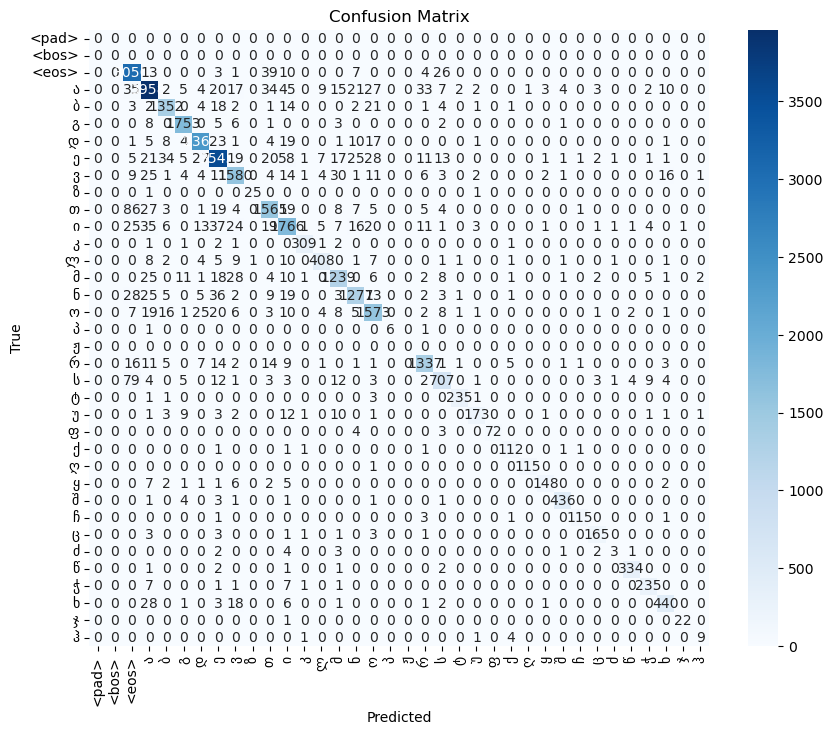

In [90]:
# confustion matrix and heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(test_targets, test_predictions, labels=list(target_vocab_dict.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(target_vocab_dict.keys()), yticklabels=list(target_vocab_dict.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Encoded (input) sequence:
<bos> ა შ ე ნ ე ბ ს ARGNO2S ARGAC1S IND PRS <eos>
Decoded (target) sequence:
<bos> მ ა შ ე ნ ე ბ <eos>
Encoded (input) indices:
[1, 3, 27, 7, 15, 7, 4, 20, 45, 37, 51, 56, 2]
Decoded (target) indices:
[1, 14, 3, 27, 7, 15, 7, 4, 2]


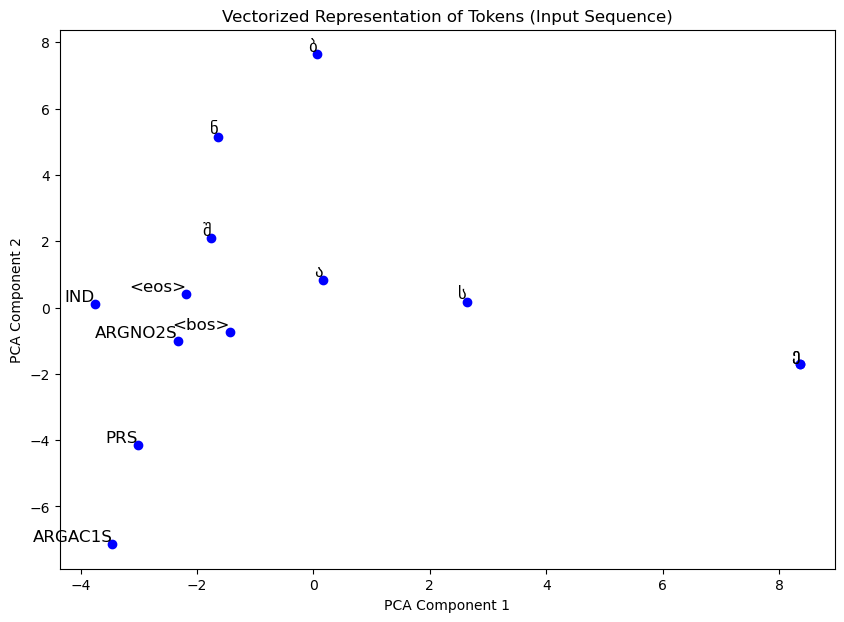

In [97]:
# Visualize vectorized representations of tokens with labels and print sequences

from sklearn.decomposition import PCA

# Example: Visualize the first sequence from X_train_idx and its decoded form
encoded_tokens = torch.tensor(X_train_idx[0])
embedded_tokens = encoder.embedding(encoded_tokens).detach().numpy()

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedded_tokens)

# Get token strings for the input sequence
idx_to_token = {idx: tok for tok, idx in feature_vocab_dict.items()}
input_tokens = [idx_to_token[idx.item()] for idx in encoded_tokens]

# Print encoded (input) and decoded (target) sequences
print("Encoded (input) sequence:")
print(" ".join(input_tokens))
print("Decoded (target) sequence:")
print(" ".join(y_train[0]))

# Print their corresponding index values from the dictionaries
input_indices = [feature_vocab_dict[token] for token in input_tokens]
target_indices = [target_vocab_dict[token] for token in y_train[0]]

print("Encoded (input) indices:")
print(input_indices)
print("Decoded (target) indices:")
print(target_indices)

# Plot the embeddings with token labels
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue')
for i, token in enumerate(input_tokens):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], token, fontsize=12, ha='right', va='bottom')
plt.title('Vectorized Representation of Tokens (Input Sequence)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()